# A simple neural network to assess clawedness in crabs

This notebook trains and evaluate a simple neural network which predict male fiddler crab handedness (or clawedness, i.e. right or left enlarged major claw). Images for training, validation and testing were obtained using [Crabspy](https://github.com/CexyNature/Crabspy).

The project folder structure is as follow:

`project/
|--- README.md
|--- requirements.txt
|--- handedness_crabs.ipynb
|--- train/
|      |--- left/      
|      |        left_xxx.jpg
|      |        ...
|      |--- right/
|               right_xxx.jpg
|               ...
|--- validation/
|      |--- left/      
|      |        left_yyy.jpg
|      |        ...
|      |--- right/
|               right_yyy.jpg
|               ...
|--- test/
|      |--- test_images/
|               left_zzz.jpg
|               ...
|               right_zzz.jpg
|               ...`

Data was divided following the next ratios: 

*Training /Validation* : *Test* = 0.8 : 0.2

*Training* : *Validation* = 0.8 : 0.2


Thus, the absolute *training : validation : test* ratios are **0.64 : 0.16 : 0.2**

Notice that training data is used to calculate model parameters, validation data is used to make decisions on the parameters (tuning), and test data is only used to calculate the performance of the model.

In [1]:
import tensorflow as tf
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.preprocessing import image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import pydot
from keras.utils.vis_utils import plot_model
from IPython.display import Image 
import os
import random

%matplotlib inline

print("Using Tensorflow {}".format(tf.__version__))

Using TensorFlow backend.


Using Tensorflow 1.13.1


## Loading images

All images are top-down views of male *Tubuca polita* fiddler crabs. All images were scaled to 30 by 30 pixels.

In [2]:
# Define directory paths for training images
train_left_dir = os.path.join('train/left')
train_right_dir = os.path.join('train/right')

# Define directory paths for validation images
val_left_dir = os.path.join('validation/left')
val_right_dir = os.path.join('validation/right')

# Get all training images file names
train_left_names = os.listdir(train_left_dir)
train_right_names = os.listdir(train_right_dir)
# print(train_left_names[:10])
# print(train_right_names[:10])
print('Total training images for label Left:', len(os.listdir(train_left_dir)))
print('Total training images for label Right:', len(os.listdir(train_right_dir)))

# Get all validation images file names
val_left_names = os.listdir(val_left_dir)
val_right_names = os.listdir(val_right_dir)
# print(validation_left_names[:10])
# print(validation_right_names[:10])
print('Total validation images for label Left:', len(os.listdir(val_left_dir)))
print('Total validation images for label Right:', len(os.listdir(val_right_dir)))

Total training images for label Left: 1234
Total training images for label Right: 1725
Total validation images for label Left: 309
Total validation images for label Right: 431


## Visualizing images

Randomly select 48 samples from each label and show them using `matplotlib`.

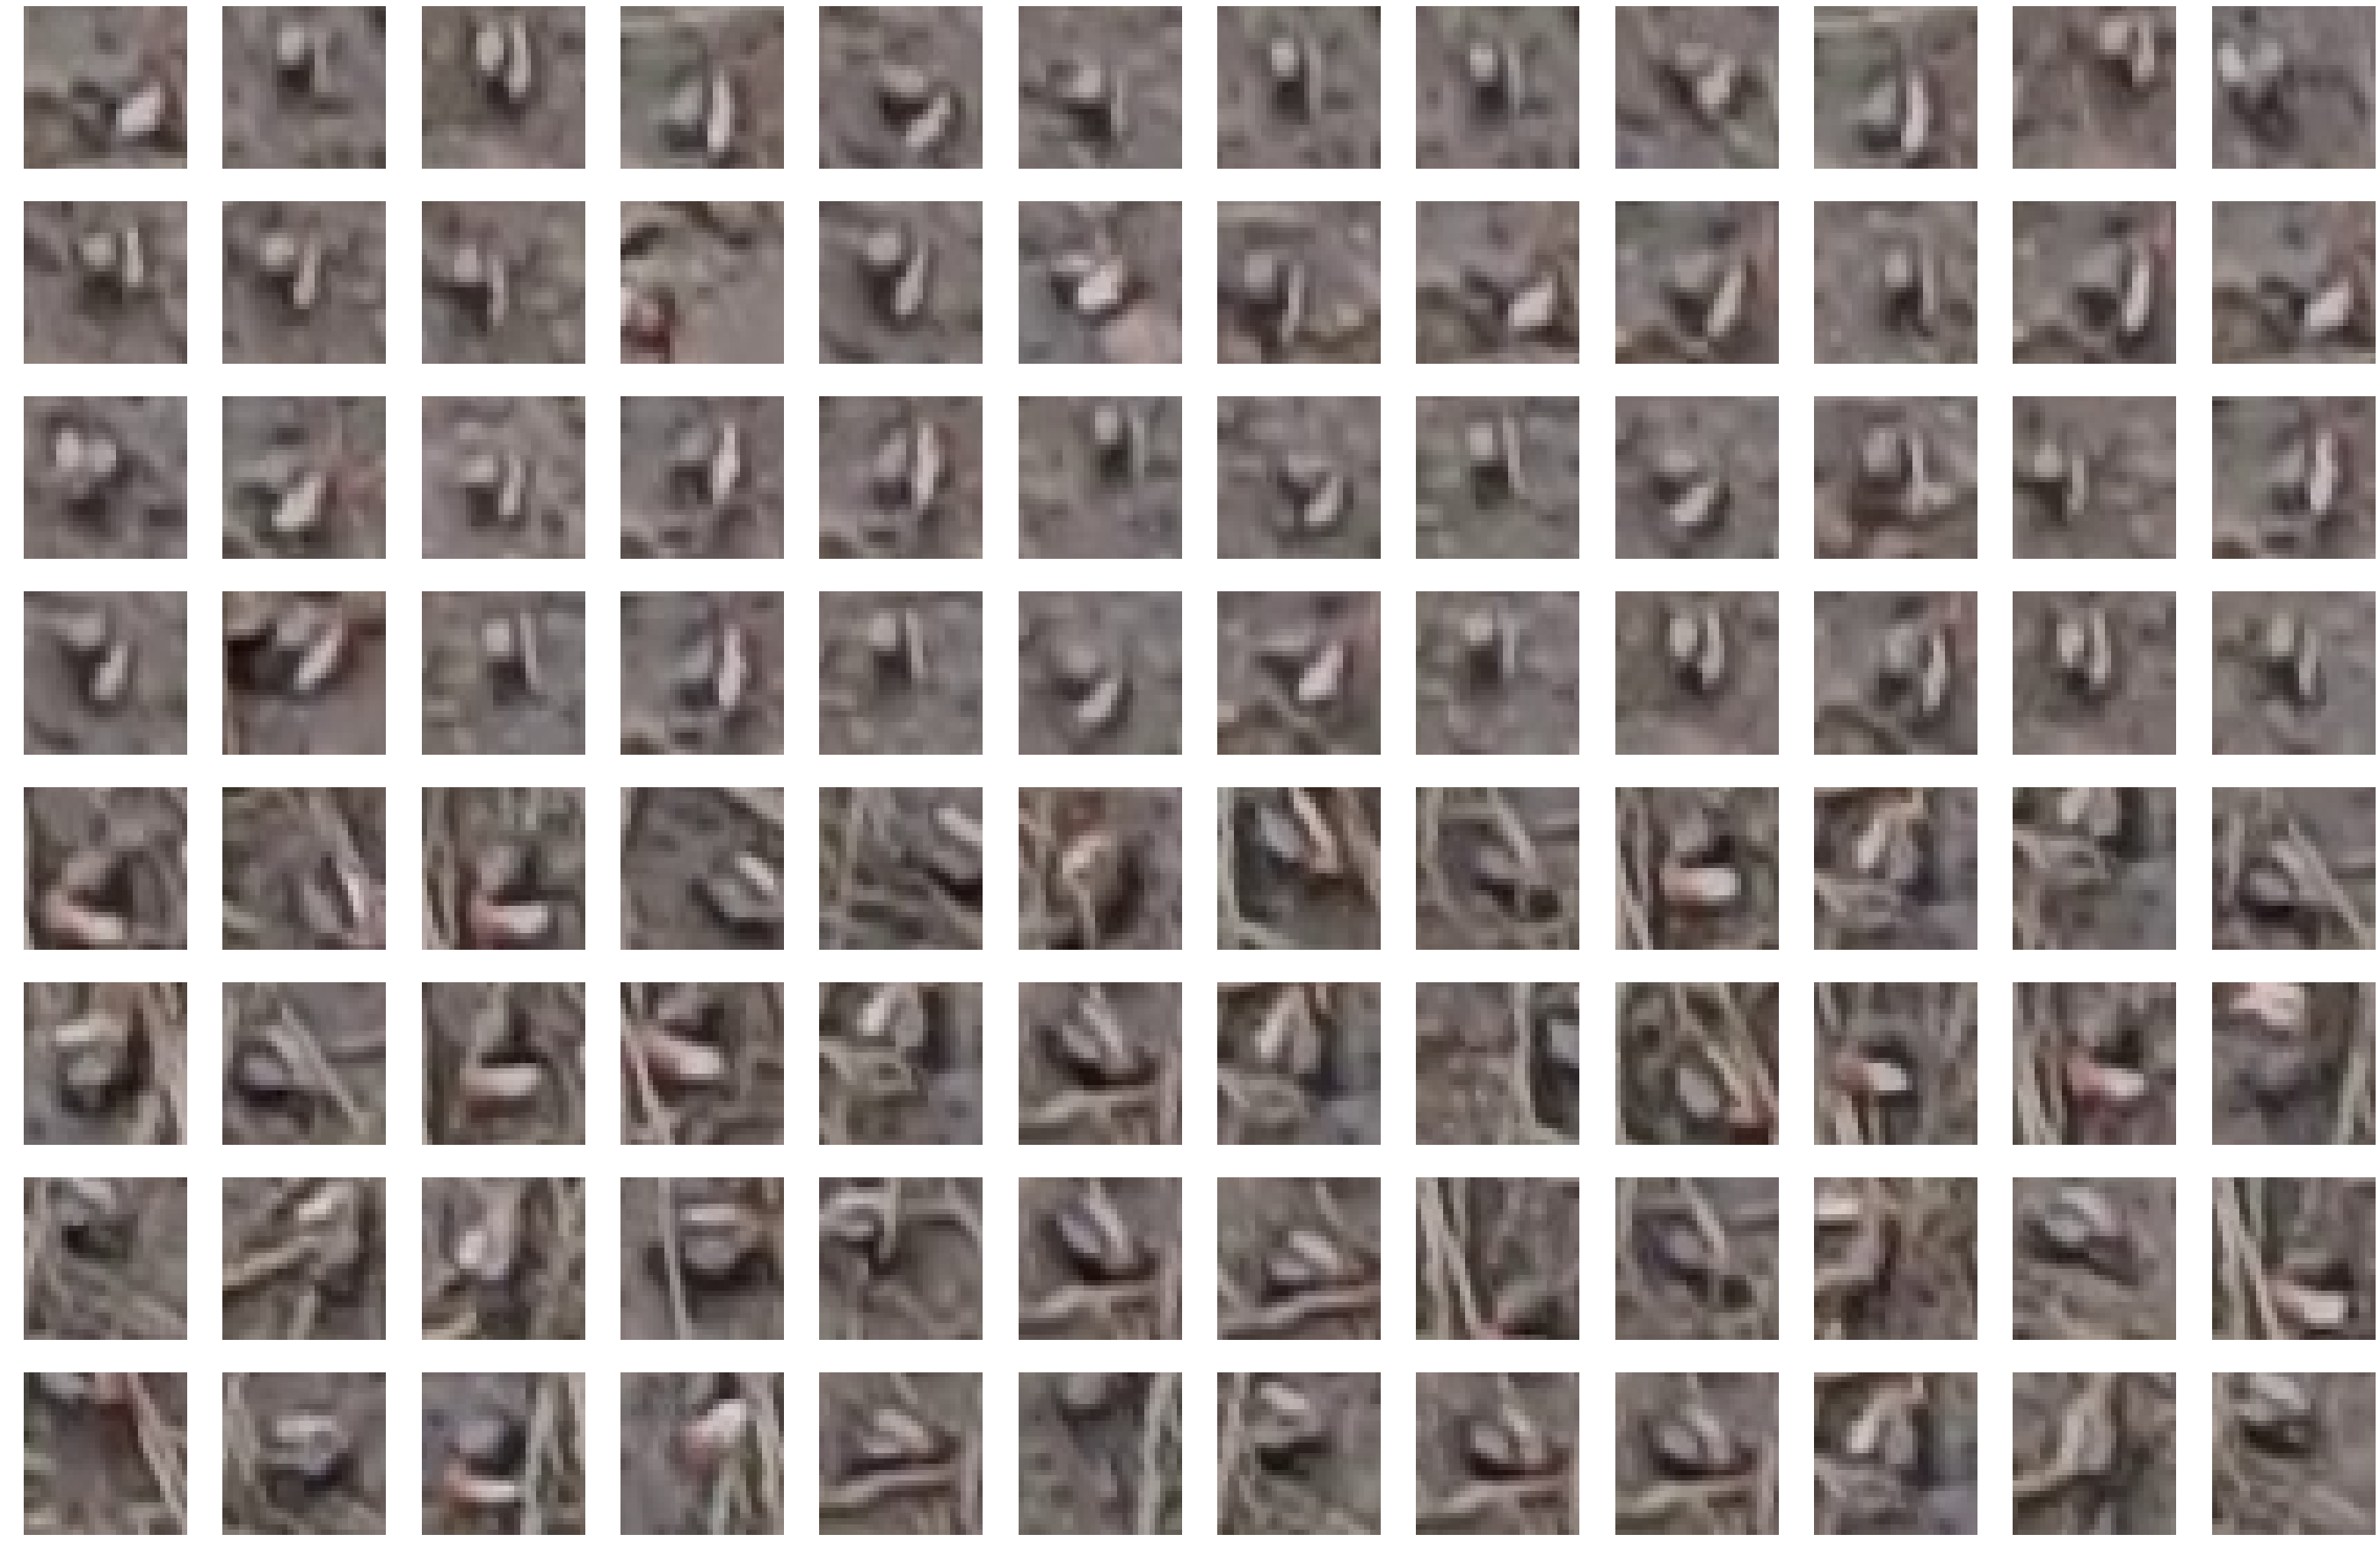

In [3]:
# Define rows and columns number for matrix of images
nrows = 8
ncols = 12

# Create figure
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# Ideally `n_pics` x 2 should be a multiple of nrows and ncols
n_pics = 48

next_left_pix = [os.path.join(train_left_dir, fname) for fname in random.sample(train_left_names, 48)]
next_right_pix = [os.path.join(train_right_dir, fname) for fname in random.sample(train_right_names, 48)]
 
for i, img_path in enumerate(next_left_pix+next_right_pix):
    # Important to remember that ubplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)
 
plt.show()

# Create Tensorflow model

The model below contains 3 convolution layers activated using a Rectified Linear Unit (ReLU) function, and three successive Max Pooling layers to reduce dimensions. The output layer uses a sigmoid function.

In [4]:
model = tf.keras.models.Sequential([
    # First convolution
    tf.keras.layers.Conv2D(24, (3,3), activation='relu', input_shape=(30, 30, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Second convolution
    tf.keras.layers.Conv2D(48, (3,3), activation='relu'),
    #     tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third convolution
#     tf.keras.layers.Conv2D(148, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
#     tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 label ('left') and 1 for the other ('right')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 24)        672       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 48)        10416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 48)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          27712     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flat

## Compailing model

The model uses the RMSprop optimizer for adaptive learning, using the suggested learning rate value of 0.001. Given the aim of this model, i.e. classify images into one of two possible labels, the loss function is set to the `binary_crossentropy` metric. This function is computed for each batch. The metrics used to evaluate the model evolution are accuracy and binary crossentropy (`acc` and `binary_crossentropy`). These metrics are calculated at the end of each epoch.

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['binary_crossentropy', 'acc'])

## Data augmentation

Raw training images are used for on-the-fly data augmentation using Keras/Tensorflow `ImageDataGenerator` function. These new images will be used during training, in both train and validation images. The number of images yielded per batch is 32. All new images are rescaled in their pixel values. 

In [6]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   rescale=1./255)
 
# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'train/',  # This is the source directory for training images
        target_size=(30, 30),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        shuffle = True)

Found 2959 images belonging to 2 classes.


In [7]:
print(train_generator.n)
print(train_generator.batch_size)
train_generator.n // train_generator.batch_size

2959
32


92

In [8]:
validation_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   rescale=1./255)
 
# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'validation/',  # This is the source directory for training images
        target_size=(30, 30),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        shuffle = True)

Found 740 images belonging to 2 classes.


In [9]:
print(validation_generator.n)
print(validation_generator.batch_size)
validation_generator.n // validation_generator.batch_size

740
32


23

## Training

The model will run a total of 100 epochs.

In [10]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=93,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=24,
                              verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
93/93 [==============================] - 9s 93ms/step - loss: 0.7843 - binary_crossentropy: 0.6622 - acc: 0.5897 - val_loss: 0.7131 - val_binary_crossentropy: 0.6778 - val_acc: 0.5432
Epoch 2/100
93/93 [==============================] - 5s 58ms/step - loss: 0.5827 - binary_crossentropy: 0.5509 - acc: 0.7094 - val_loss: 0.4779 - val_binary_crossentropy: 0.4440 - val_acc: 0.8108
Epoch 3/100
93/93 [==============================] - 5s 58ms/step - loss: 0.4876 - binary_crossentropy: 0.4540 - acc: 0.7780 - val_loss: 0.4186 - val_binary_crossentropy: 0.3802 - val_acc: 0.8473
Epoch 4/100
93/93 [==============================] - 7s 70ms/step - loss: 0.4409 - binary_crossentropy: 0.4059 - acc: 0.8249 - val_loss: 0.3915 - val_binary_crossentropy: 0.3467 - val_acc: 0.8730
Epoch 5/100
93/93 [==============================] - 6s 64ms/step - loss: 0.3700 - binary_crossentropy: 0.3314 - acc: 0.8611 - val_loss: 0.3234 - val_binary_crossentrop

93/93 [==============================] - 6s 63ms/step - loss: 0.1005 - binary_crossentropy: 0.0712 - acc: 0.9726 - val_loss: 0.0738 - val_binary_crossentropy: 0.0449 - val_acc: 0.9892
Epoch 53/100
93/93 [==============================] - 5s 57ms/step - loss: 0.1029 - binary_crossentropy: 0.0755 - acc: 0.9716 - val_loss: 0.0768 - val_binary_crossentropy: 0.0515 - val_acc: 0.9838
Epoch 54/100
93/93 [==============================] - 5s 57ms/step - loss: 0.0940 - binary_crossentropy: 0.0670 - acc: 0.9784 - val_loss: 0.0833 - val_binary_crossentropy: 0.0567 - val_acc: 0.9811
Epoch 55/100
93/93 [==============================] - 5s 55ms/step - loss: 0.0833 - binary_crossentropy: 0.0570 - acc: 0.9780 - val_loss: 0.0709 - val_binary_crossentropy: 0.0461 - val_acc: 0.9865
Epoch 56/100
93/93 [==============================] - 5s 57ms/step - loss: 0.1014 - binary_crossentropy: 0.0738 - acc: 0.9770 - val_loss: 0.0656 - val_binary_crossentropy: 0.0405 - val_acc: 0.9878
Epoch 57/100
93/93 [========

93/93 [==============================] - 5s 55ms/step - loss: 0.0784 - binary_crossentropy: 0.0545 - acc: 0.9780 - val_loss: 0.0498 - val_binary_crossentropy: 0.0273 - val_acc: 0.9892
Epoch 79/100
93/93 [==============================] - 5s 50ms/step - loss: 0.0701 - binary_crossentropy: 0.0469 - acc: 0.9834 - val_loss: 0.0632 - val_binary_crossentropy: 0.0412 - val_acc: 0.9905
Epoch 80/100
93/93 [==============================] - 5s 56ms/step - loss: 0.0659 - binary_crossentropy: 0.0429 - acc: 0.9834 - val_loss: 0.0499 - val_binary_crossentropy: 0.0280 - val_acc: 0.9851
Epoch 81/100
93/93 [==============================] - 5s 56ms/step - loss: 0.0837 - binary_crossentropy: 0.0613 - acc: 0.9818 - val_loss: 0.0614 - val_binary_crossentropy: 0.0400 - val_acc: 0.9878
Epoch 82/100
93/93 [==============================] - 5s 54ms/step - loss: 0.0725 - binary_crossentropy: 0.0498 - acc: 0.9841 - val_loss: 0.0592 - val_binary_crossentropy: 0.0376 - val_acc: 0.9892
Epoch 83/100
93/93 [========

## Evaluate model training

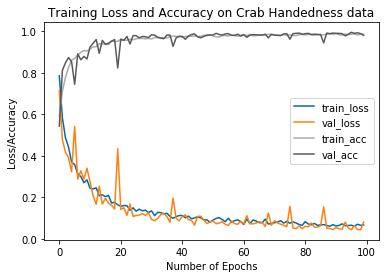

In [11]:
N = np.arange(0, 100)
plt.style.use("tableau-colorblind10")
# plt.style.use("dark_background")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["acc"], label="train_acc")
plt.plot(N, history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Crab Handedness data")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
# plt.savefig(args["plot"])

## Saving model

The model is saved for later used.

In [12]:
model.save("handedness_model.h5")

## Loading model


In [13]:
# # Recreate the exact same model, including its weights and the optimizer
# model = tf.keras.models.load_model("handedness_model_classic_v4_highercapacity_flipT.h5")
# # Show the model architecture
# model.summary()

## Testing model

This model is tested using two approaches: model.predict_generator and model.predict. Please observe that testing images were not seen by the model before. Thus, these are useful for estimating model performance.

### *model.predict_generator()*

The *predict_generator* uses the `ImageDataGenerator` function from Keras to create test batches. The advantage of using *predict_generator* is that no all data have to be loaded into memory. Instead, data is loading in batches during the testing. By using this method, the user has the alternative to perform data augmentation on the testing set. This decision is subject to the objective of the experiment. While most people do not apply augmentation in testing sets, there are few instances were this could be useful.


Please notice that the test `ImageDataGenerator` is applying transformations to the testing images. For this reason, every time the code below is ran the results could be slightly different. However, it is also possible to just feed raw images to the `test_generator` by commenting out all `ImageDataGenerator` transformations.

In [14]:
test_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=False,
                                   fill_mode="nearest",
                                   rescale=1./255)




test_generator = test_datagen.flow_from_directory(
        'test/',  # This is the source directory for training images
        target_size=(30, 30),
        batch_size=12,
        class_mode=None,
        shuffle = False)

Found 924 images belonging to 1 classes.


In [15]:
test_generator.n//test_generator.batch_size

77

In [16]:
test_generator.reset()
probabilities = model.predict_generator(test_generator,
                              steps=77, verbose=1)

77/77 [==============================] - 2s 22ms/step


In [17]:
predicted_class_indices=np.around(probabilities, decimals=0).flatten()
# predicted_class_indices

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"Image":filenames,
                      "Prediction":predictions})
results.to_csv("handedness_prediction_results_testgenerator_v1.csv",index=False)

Clawdeness predictions for each image in the testing set are saved in a file. A confusion matrix is calculated based on the model prediction and the actual image category (i.e. left or right).

The confusion matrix follows the following structure:

`([True Positive, False Positive] 
  [False Negative, True Negative])`
  
Thus, the diagonal (with negative slope) represents the number of images for which the labels/categories were correctly predicted. First row corresponds to the left category and second row corresponds to right category.

In [18]:
y_true = np.array([0] * 385 + [1] * 539)
y_pred = probabilities > 0.5

confusion_matrix(y_true, y_pred)

array([[371,  14],
       [  2, 537]], dtype=int64)

### *model.predict()*

*predict* compute the predictions for the input samples.

### Important note

Both testing methods should result in similar results. Therefore, both of them are reported here just as a congruency check.

In [19]:
test_dir = os.path.join('test/test_images/')
test_imgs = os.listdir(test_dir)

res= []
probabilities_raw = []

for fn in test_imgs:

  path = test_dir + fn
  img = image.load_img(path, target_size=(30, 30)) 
  x = image.img_to_array(img) * 1/255
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  category = model.predict(images, batch_size=924)
  probabilities_raw.append(category[0])
#     print(category[0])
  if category[0]>0.5:
#     print(fn + " is right clawedness")
    res.append([fn, "right"])
  else:
#     print(fn + " is left clawedness")
    res.append([fn, "left"])
    
res = pd.DataFrame(res)
res.to_csv("handedness_prediction_results_testraw_v1.csv",index=False, header=["Image", "Prediction"])

As with the previous method, predictions are saved in a file. The confusion matrix is shown below.

In [20]:
y_true_raw = np.array([0] * 385 + [1] * 539)
y_pred_raw = np.asarray(probabilities_raw) > 0.5

confusion_matrix(y_true_raw, y_pred_raw)

array([[374,  11],
       [  0, 539]], dtype=int64)

## Visualizing Convolutional Sparse representations

The code below recreate the model used during training, then it is used to create a visualization of the activated neurons for an example image.

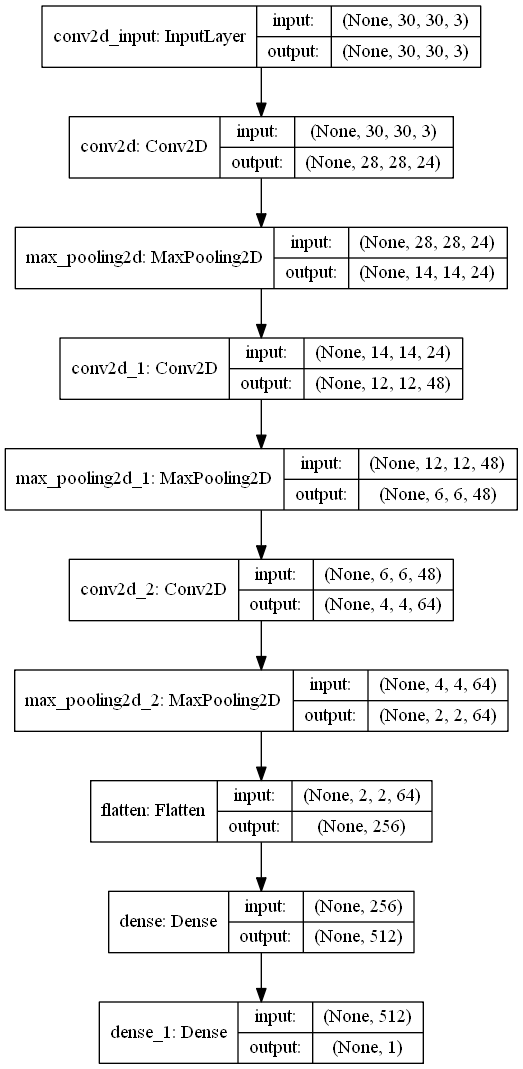

In [21]:
# Get names, shape and dtype for all model layers
layers = [layer.output for layer in model.layers[1:]]

# Create an inference model based on the model input and outputs
viz_model = tf.keras.models.Model(inputs = model.input, outputs = layers)
tf.keras.utils.plot_model(viz_model, to_file="model_img.png", show_shapes=True,  show_layer_names=True, rankdir='TB')
Image("model_img.png")

The code below shows the activiation of ReLU neurons across features and layers.

C:\Users\Sheaves_Lab\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


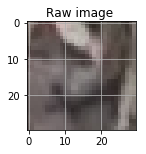

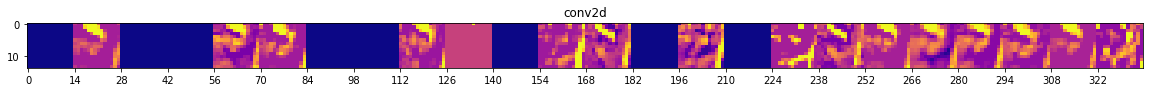

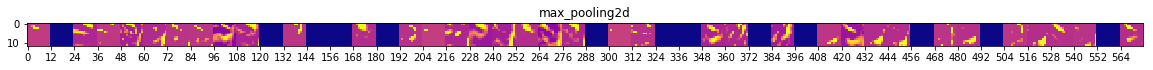

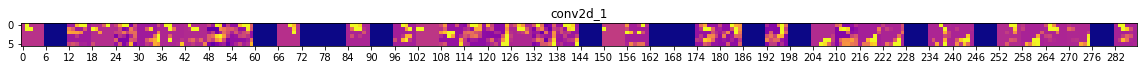

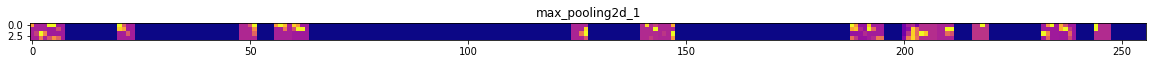

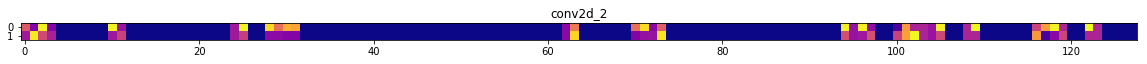

In [22]:
# Select one random image from the training set
left_img_files = [os.path.join(train_left_dir, f) for f in train_left_names]
right_img_files = [os.path.join(train_right_dir, f) for f in train_right_names]
img_path = random.choice(left_img_files + right_img_files)
 
img = load_img(img_path, target_size=(30, 30))
x = img_to_array(img)  # Numpy array with shape (30, 30, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 30, 30, 3)
# Rescale by 1/255
x /= 255


# Show the image selected
fig, ax = plt.subplots(figsize=(2, 2))
fig.suptitle('Raw image')
imgp = mpimg.imread(img_path)
ax.grid(b=None)
ax.imshow(imgp)


# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = viz_model.predict(x)
 
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
 
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    
    # Filter out layers with less than 4 dimensions (e.g. last maxpooling, flatten and dense layers)
    # Thus, fully-connected layers are ignored
    
    if len(feature_map.shape) == 4:
        
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        
        for i in range(n_features):
            
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i] # select each feature
            # Starndardize each pixel value
            x -= x.mean()
            x /= x.std()
            # Arbitrary add pixel intensity
            x *= 64
            x += 128
            # Clip values above or beyod limits
            x = np.clip(x, 0, 255).astype('uint8')
            
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
        
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        if size >= 6:
            plt.xticks(np.arange(0, size * n_features, step = size))
        plt.imshow(display_grid, aspect = 'auto', cmap = 'plasma')